# Загрузка и предобработка файлов с историческими погодными данными городов России.

**Параметры:**  
**temperature_2m** — температура на высоте 2 м, измеряется в °С.  
**relative_humidity_2m** — относительная влажность на высоте 2 м, измеряется в процентах от 0 до 100.  
**rain** — дождь за предыдущий час, измеряется в миллиметрах.  
**snowfall** — снегопад, количество выпавшего снега за предыдущий час в сантиметрах.  
**snow_depth** — глубина снега, измеряется в метрах.  
**is_day** — день или ночь, 1 - если в текущем временном шаге есть дневной свет,0 - ночью.  
**precipitation** — осадки, общее количество осадков (дождь, ливни, снег) за предыдущий час, измеряется в миллиметрах.
**wind_direction_100m** — направление ветра на высоте 100 м, выражается в градусах.  
**wind_speed_100m** — скорость ветра на высоте 100 м, измеряется в км/ч.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

!pip install geohash2

import geohash2

import sqlite3

import pickle

  Preparing metadata (setup.py) ... done
  Created wheel for geohash2: filename=geohash2-1.1-py3-none-any.whl size=15543 sha256=fbcb7a45530139fc86e53cd0e185ca78b4841d227dfed86988052cdb61c33d29
  Stored in directory: /root/.cache/pip/wheels/f6/7c/c4/1b3c6fea0ebc53bf730dc86bbee7a713d501455dfb4c1f0623
Successfully built geohash2


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/weather_data.parquet')

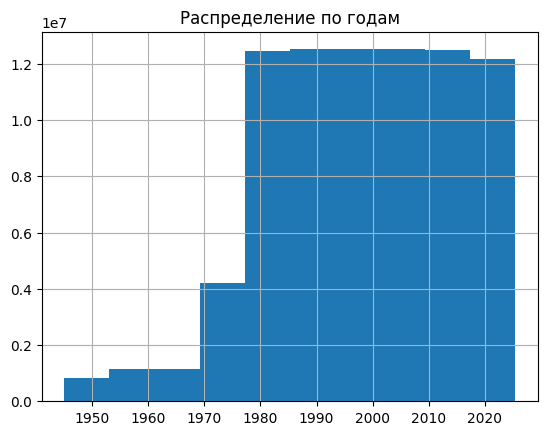

In [ ]:
df['date'].hist()
plt.title('Распределение по годам')
plt.show()

Данные в общем датасете распределены по годам не равномерно. Поэтому будем делать выборку за последние 50 лет (с 1975 по 2024гг.).

## Города 1 группы

In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/group_1.csv')

In [ ]:
df_1.head()

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
0,1975-01-01 00:00:00+00:00,Алзамай,-19.518501,82.294174,0.0,0.0,0.6,0.0,0.0,165.96373,1.484318
1,1975-01-01 06:00:00+00:00,Алзамай,-16.518501,76.592300,0.0,0.0,0.6,1.0,0.0,203.96250,3.545589
2,1975-01-01 12:00:00+00:00,Алзамай,-19.418500,82.308586,0.0,0.0,0.6,0.0,0.0,212.61923,10.685391
3,1975-01-01 18:00:00+00:00,Алзамай,-22.318500,79.705460,0.0,0.0,0.6,0.0,0.0,208.44283,9.826088
4,1975-01-02 00:00:00+00:00,Алзамай,-23.418500,78.803050,0.0,0.0,0.6,0.0,0.0,226.27295,11.457958


In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15912540 entries, 0 to 15912539
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date                  object 
 1   city                  object 
 2   temperature_2m        float64
 3   relative_humidity_2m  float64
 4   rain                  float64
 5   snowfall              float64
 6   snow_depth            float64
 7   is_day                float64
 8   precipitation         float64
 9   wind_direction_100m   float64
 10  wind_speed_100m       float64
dtypes: float64(9), object(2)
memory usage: 1.3+ GB


Данные по дате представлены в формате *object*. Необходимо будет привести к нужному типу.  
Проверим дубликаты.

In [ ]:
df_1.duplicated().sum()

np.int64(4347)

Выявили 4347 строк полных дублей.  
Посмотрим их и дальше удалим.

In [ ]:
df_1[df_1.duplicated(keep=False)].head(10)

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
10458608,1975-01-01 00:00:00+00:00,Адыгейск,1.683,98.932210,1.4,0.07,0.00,0.0,1.5,17.102825,14.689589
10458609,1975-01-01 06:00:00+00:00,Адыгейск,0.883,97.508140,1.4,1.12,0.01,1.0,3.0,358.994930,20.523155
10458610,1975-01-01 12:00:00+00:00,Адыгейск,-1.067,92.233800,0.0,6.37,0.06,1.0,9.1,39.559640,10.739832
10458611,1975-01-01 18:00:00+00:00,Адыгейск,-2.117,93.550560,0.0,1.19,0.07,0.0,1.7,34.695220,11.384198
10458612,1975-01-02 00:00:00+00:00,Адыгейск,-2.867,92.814150,0.0,0.07,0.07,0.0,0.1,53.972538,9.793059
10458613,1975-01-02 06:00:00+00:00,Адыгейск,-3.667,91.723960,0.0,0.00,0.08,1.0,0.0,86.906006,13.339445
10458614,1975-01-02 12:00:00+00:00,Адыгейск,-2.167,81.434090,0.0,0.00,0.07,1.0,0.0,61.049107,19.336390
10458615,1975-01-02 18:00:00+00:00,Адыгейск,-4.567,84.923600,0.0,0.00,0.07,0.0,0.0,47.121110,27.511158
10458616,1975-01-03 00:00:00+00:00,Адыгейск,-6.217,83.745445,0.0,0.00,0.07,0.0,0.0,52.193413,26.427530
10458617,1975-01-03 06:00:00+00:00,Адыгейск,-7.917,84.858540,0.0,0.00,0.07,1.0,0.0,47.935760,19.881649


In [ ]:
df_1.drop_duplicates(inplace = True)

Приведем тип данных в столбце *is_day* к булевому типу.  
А значения с типом *float64* поменяем на *float32* для экономии памяти.

In [ ]:
df_1['is_day'] = df_1['is_day'].astype('bool')

In [ ]:
# Находим все столбцы с типом float64
float64_cols = df_1.select_dtypes(include='float64').columns

# Меняем тип этих столбцов на float32
df_1[float64_cols] = df_1[float64_cols].astype('float32')

Меняем тип даты.

In [ ]:
df_1.insert(0,'datetime', pd.to_datetime(df_1['date'],format='%Y-%m-%d %H:%M:%S%z',errors='coerce').dt.tz_localize(None))
mask = df_1['datetime'].isna()
df_1.loc[mask, 'datetime'] = pd.to_datetime(df_1.loc[mask, 'date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df_1 = df_1.drop(['date'], axis=1)
df_1 = df_1.rename(columns={'datetime': 'date'})

In [ ]:
df_1.dtypes

,0
date,datetime64[ns]
city,object
temperature_2m,float32
relative_humidity_2m,float32
rain,float32
snowfall,float32
snow_depth,float32
is_day,bool
precipitation,float32
wind_direction_100m,float32


Сделаем срез по датам

In [ ]:
df_1 = df_1[df_1['date'].dt.year >= 1975].reset_index(drop = True)
df_1 = df_1[df_1['date'].dt.year <= 2024].reset_index(drop = True)

Посмотрим на значения городов, чтобы выявить неявные дубли или неправильное написание названия.

In [ ]:
df_1['city'].sort_values().unique()

array(['Абдулино', 'Адыгейск', 'Ак-Довурак', 'Алапаевск', 'Алейск',
       'Алзамай', 'Андреаполь', 'Апрелевка', 'Арамиль', 'Ардатов',
       'Армавир', 'Асино', 'Астрахань', 'Ачинск', 'Аша', 'Бабушкин',
       'Бакал', 'Балаково', 'Балей', 'Батайск', 'Белоусово', 'Белёв',
       'Бирюсинск', 'Болгар', 'Бологое', 'Большой Камень', 'Борисоглебск',
       'Боровск', 'Бородино', 'Бузулук', 'Бутурлиновка',
       'Великий Новгород', 'Верещагино', 'Ветлуга', 'Волжский', 'Вологда',
       'Волоколамск', 'Волчанск', 'Воткинск', 'Выборг', 'Вышний Волочёк',
       'Вяземский', 'Вязники', 'Гай', 'Геленджик', 'Городище', 'Губаха',
       'Демидов', 'Дивногорск', 'Дигора', 'Димитровград', 'Донецк',
       'Донской', 'Дубовка', 'Емва', 'Ермолино', 'Ефремов',
       'Железноводск', 'Жуковский', 'Завитинск', 'Заволжск', 'Заинск',
       'Заозёрный', 'Заозёрск', 'Зверево', 'Зеленоградск', 'Зеленодольск',
       'Зерноград', 'Зима', 'Златоуст', 'Злынка', 'Змеиногорск', 'Зуевка',
       'Ивангород', 'Ив

Составим список городов, куда будем добавлять все названия из разных групп. Чтобы потом проверить каких городов не хватает.

In [ ]:
all_cities = df_1['city'].sort_values().unique().tolist()

Посмотрим пропуски.

In [ ]:
df_1.isna().sum()

,0
date,0
city,0
temperature_2m,0
relative_humidity_2m,0
rain,0
snowfall,0
snow_depth,73052
is_day,0
precipitation,0
wind_direction_100m,0


Есть пропуски в параметре *snow_depth* - глубина снега.

In [ ]:
df_1[df_1['snow_depth'].isna()]['city'].unique()

array(['Геленджик'], dtype=object)

In [ ]:
df_1[df_1['snow_depth'].isna()]['date'].unique()

<DatetimeArray>
['1975-01-01 00:00:00', '1975-01-01 06:00:00', '1975-01-01 12:00:00',
 '1975-01-01 18:00:00', '1975-01-02 00:00:00', '1975-01-02 06:00:00',
 '1975-01-02 12:00:00', '1975-01-02 18:00:00', '1975-01-03 00:00:00',
 '1975-01-03 06:00:00',
 ...
 '2024-12-29 12:00:00', '2024-12-29 18:00:00', '2024-12-30 00:00:00',
 '2024-12-30 06:00:00', '2024-12-30 12:00:00', '2024-12-30 18:00:00',
 '2024-12-31 00:00:00', '2024-12-31 06:00:00', '2024-12-31 12:00:00',
 '2024-12-31 18:00:00']
Length: 73052, dtype: datetime64[ns]

Данные по параметру `глубина снега` отсутствуют только в городе *Геленджик* за весь период.
Поскольку это южный город, на данном этапе добавлять значения не будем.  Попробуем повторить выгрузку.

Проверим неявные дубли, исключив данные по датам.

In [ ]:
columns_ignore  = df_1.columns.difference(['date'])
duplicates = df_1[df_1.duplicated(subset=columns_ignore , keep = False)]
duplicates

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
1098052,1976-07-22 00:00:00,Донской,12.243500,86.139099,0.0,0.0,0.00,False,0.0,28.610369,22.553936
1139687,2005-01-19 18:00:00,Донской,-7.506500,90.046753,0.0,0.0,0.11,False,0.0,169.380402,23.441502
1139688,2005-01-20 00:00:00,Донской,-7.506500,90.046753,0.0,0.0,0.11,False,0.0,169.380402,23.441502
1146052,2009-05-30 00:00:00,Донской,12.243500,86.139099,0.0,0.0,0.00,False,0.0,28.610369,22.553936
2148668,1995-08-24 00:00:00,Кстово,13.094000,93.040703,0.0,0.0,0.00,False,0.0,280.375793,25.984917
...,...,...,...,...,...,...,...,...,...,...,...
14729096,2007-03-20 18:00:00,Семилуки,5.574500,73.313263,0.0,0.0,0.00,False,0.0,148.348770,30.871965
15555122,2022-08-02 06:00:00,Истра,19.986500,66.838043,0.0,0.0,0.00,True,0.0,138.503632,12.496718
15558170,2024-09-02 06:00:00,Истра,19.986500,66.838043,0.0,0.0,0.00,True,0.0,138.503632,12.496718
15584335,1992-07-30 12:00:00,Качканар,17.668501,51.047241,0.0,0.0,0.00,True,0.0,70.640915,14.118243


Выявили 70 строк с дублями по параметрам без привязки к датам.  
Запишем название городов для повторного скачивания.  
И удалим дубли.

In [ ]:
cities_download = set(duplicates['city'])
len(cities_download)

28

In [ ]:
df_1.drop_duplicates(subset = df_1.columns.difference(['date']), inplace = True)

Посмотрим описательные характеристики.

In [ ]:
df_1.describe().T

,count,mean,min,25%,50%,75%,max,std
date,15777774,2000-01-01 13:22:00.591687040,1975-01-01 00:00:00,1987-07-02 06:00:00,2000-01-02 06:00:00,2012-07-02 12:00:00,2024-12-31 21:00:00,NaN
temperature_2m,15777774.0,4.456345,-59.473,-3.7725,4.8455,14.6395,42.810997,12.766863
relative_humidity_2m,15777774.0,74.988701,5.449474,65.139378,78.608307,87.738325,100.0,16.617529
rain,15777774.0,0.260484,0.0,0.0,0.0,0.0,92.200005,1.054669
snowfall,15777774.0,0.070803,0.0,0.0,0.0,0.0,17.570002,0.313199
snow_depth,15704722.0,0.136114,0.0,0.0,0.0,0.22,1.72,0.216968
precipitation,15777774.0,0.351053,0.0,0.0,0.0,0.1,92.200005,1.126619
wind_direction_100m,15777774.0,195.550476,0.280862,116.564987,208.810699,274.085541,360.0,96.403732
wind_speed_100m,15777774.0,20.752594,0.0,13.450708,20.240198,27.067116,107.220184,9.848948


На данный момент в России зарегестрированы максимальная температура +45,4 °С и минимальная -67,8°С; так что разброс значений температуры соответствует.  

Максимальная глубина снега в России может достигать 7 метров.  

Максимальная скорость ветра доходила до 187км/ч.  

Все остальные параметры так же вписываются в естественное распределение.

### Добавляем датасет с данными по городам

In [ ]:
city = pd.read_csv('/content/drive/MyDrive/city_data_good.csv')

In [ ]:
city.head(1)

,id,name,region,federal_district,population,foundation_year,status,old_name,latitude,longitude
0,1,Абаза,Хакасия,Сибирский,12272,1867,1966,"Абаканский Завод, Абаканско-Заводское",52.651055,90.101159


In [ ]:
city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1125 non-null   int64  
 1   name              1125 non-null   object 
 2   region            1125 non-null   object 
 3   federal_district  1125 non-null   object 
 4   population        1125 non-null   int64  
 5   foundation_year   1125 non-null   object 
 6   status            1122 non-null   object 
 7   old_name          593 non-null    object 
 8   latitude          1125 non-null   float64
 9   longitude         1125 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 88.0+ KB


Меняем тип данных.

In [ ]:
# Находим все столбцы с типом float64
float64_cols = city.select_dtypes(include='float64').columns

# Меняем тип этих столбцов на float32
city[float64_cols] = city[float64_cols].astype('float32')

Добавляем *geohash* по широте и долготе вместо *id* для уникального значения.

In [ ]:
city['id'] = city.apply(
    lambda x: geohash2.encode(x['latitude'], x['longitude'], precision=7),
    axis=1
)

city.head()

,id,name,region,federal_district,population,foundation_year,status,old_name,latitude,longitude
0,y125d2c,Абаза,Хакасия,Сибирский,12272,1867,1966,"Абаканский Завод, Абаканско-Заводское",52.651055,90.101159
1,y1918g9,Абакан,Хакасия,Сибирский,184769,1734,1931,Усть-Абаканское (до 1931),53.720680,91.440602
2,v1w1kuw,Абдулино,Оренбургская область,Приволжский,17274,1795,1923,NaN,53.682800,53.655701
3,szgphr3,Абинск,Краснодарский край,Южный,39511,1863,1963,Абинское (до 1863); Абинская (до 1962),44.864953,38.157819
4,v1yq52h,Агидель,Башкортостан,Приволжский,14219,1980,1991,NaN,55.899276,53.937420


In [ ]:
city = city.rename(columns={'name': 'city', 'id': 'geohash'})

Проверяем пропуски.

In [ ]:
city.isna().sum()

,0
id,0
name,0
region,0
federal_district,0
population,0
foundation_year,0
status,3
old_name,532
latitude,0
longitude,0


Пропуски в столбцах *status* и *old_name* естественные.

Сохраняем датасет в CSV формате.

In [ ]:
city.to_csv('/content/drive/MyDrive/cities.csv', index = False)

Заменяем названия городов на *geohash*.

In [ ]:
# Используем словарь для быстрого сопоставления
geo_dict = city.set_index('city')['geohash'].to_dict()

# Заменяем через map()
df_1.insert(1,'geohash', df_1['city'].map(geo_dict))
df_1 = df_1.drop('city', axis=1)

In [ ]:
df_1.head()

,date,geohash,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
0,1975-01-01 00:00:00,y1yhj1m,-19.518501,82.294174,0.0,0.0,0.6,False,0.0,165.963730,1.484318
1,1975-01-01 06:00:00,y1yhj1m,-16.518501,76.592300,0.0,0.0,0.6,True,0.0,203.962494,3.545589
2,1975-01-01 12:00:00,y1yhj1m,-19.418501,82.308586,0.0,0.0,0.6,False,0.0,212.619232,10.685391
3,1975-01-01 18:00:00,y1yhj1m,-22.318501,79.705460,0.0,0.0,0.6,False,0.0,208.442825,9.826088
4,1975-01-02 00:00:00,y1yhj1m,-23.418501,78.803047,0.0,0.0,0.6,False,0.0,226.272949,11.457958


In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15777774 entries, 0 to 15777808
Data columns (total 11 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   geohash               object        
 2   temperature_2m        float32       
 3   relative_humidity_2m  float32       
 4   rain                  float32       
 5   snowfall              float32       
 6   snow_depth            float32       
 7   is_day                bool          
 8   precipitation         float32       
 9   wind_direction_100m   float32       
 10  wind_speed_100m       float32       
dtypes: bool(1), datetime64[ns](1), float32(8), object(1)
memory usage: 857.7+ MB


После преобразование объем данных снизился с 1,3 гб до 857,7 мб.

### Загрузка в sqlite

In [ ]:
# подключаем базу в Drive
db_path = '/content/drive/MyDrive/weather_cities.db'
conn = sqlite3.connect(db_path)

In [ ]:
# Загружаем DataFrame
df_1.to_sql('weather_cities', conn, if_exists='replace', index=False) # 'append' добавит данные

# Проверяем
print(pd.read_sql('SELECT * FROM weather_cities LIMIT 1', conn))

                  date  geohash  temperature_2m  relative_humidity_2m  rain  \
0  1975-01-01 00:00:00  y1yhj1m      -19.518501             82.294174   0.0   

   snowfall  snow_depth  is_day  precipitation  wind_direction_100m  \
0       0.0         0.6       0            0.0            165.96373   

   wind_speed_100m  
0         1.484318  


In [ ]:
# Проверяем количество строк
print(pd.read_sql('SELECT count(*) FROM weather_cities', conn))

   count(*)
0  15777809


In [ ]:
# Закрываем подключение
conn.close()

Сохраняем в CSV формат

In [ ]:
df_1['geohash'] = df_1['geohash'].astype('category')
df_1.to_csv('/content/drive/MyDrive/weather_1.csv', index = False)

## Города 2 группы

In [ ]:
df_2 = pd.read_csv('/content/drive/MyDrive/group_2.csv')

In [ ]:
df_2.head(1)

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
0,1975-01-01 00:00:00+00:00,Белинский,-5.5325,82.54212,0.0,0.0,0.41,0,0.0,250.0168,33.709534


In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18277340 entries, 0 to 18277339
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date                  object 
 1   city                  object 
 2   temperature_2m        float64
 3   relative_humidity_2m  float64
 4   rain                  float64
 5   snowfall              float64
 6   snow_depth            float64
 7   is_day                int64  
 8   precipitation         float64
 9   wind_direction_100m   float64
 10  wind_speed_100m       float64
dtypes: float64(8), int64(1), object(2)
memory usage: 1.5+ GB


In [ ]:
df_2.duplicated().sum()

np.int64(97800)

Выявили 97800 полных дублей.  
Удалим их.

In [ ]:
df_2.drop_duplicates(inplace = True)

Приведем типы данных к нужному формату.

In [ ]:
df_2['is_day'] = df_2['is_day'].astype('bool')

In [ ]:
# Находим все столбцы с типом float64
float64_cols = df_2.select_dtypes(include='float64').columns

# Меняем тип этих столбцов на float32
df_2[float64_cols] = df_2[float64_cols].astype('float32')

In [ ]:
df_2.insert(0,'datetime', pd.to_datetime(df_2['date'],format='%Y-%m-%d %H:%M:%S%z',errors='coerce').dt.tz_localize(None))
mask = df_2['datetime'].isna()
df_2.loc[mask, 'datetime'] = pd.to_datetime(df_2.loc[mask, 'date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df_2 = df_2.drop(['date'], axis=1)
df_2 = df_2.rename(columns={'datetime': 'date'})

In [ ]:
df_2.dtypes

,0
date,datetime64[ns]
city,object
temperature_2m,float32
relative_humidity_2m,float32
rain,float32
snowfall,float32
snow_depth,float32
is_day,bool
precipitation,float32
wind_direction_100m,float32


Сделаем срез по годам.

In [ ]:
df_2 = df_2[df_2['date'].dt.year >= 1975].reset_index(drop = True)
df_2 = df_2[df_2['date'].dt.year <= 2024].reset_index(drop = True)

Посмотрим названия городов.

In [ ]:
df_2['city'].sort_values().unique()

array(['Агидель', 'Агрыз', 'Алдан', 'Альметьевск', 'Арзамас', 'Арск',
       'Артёмовский', 'Архангельск', 'Аткарск', 'Баксан', 'Балабаново',
       'Балашов', 'Барабинск', 'Барыш', 'Бахчисарай', 'Белинский',
       'Белокуриха', 'Березники', 'Беслан', 'Билибино', 'Бирюч',
       'Благодарный', 'Богородск', 'Бокситогорск', 'Бугры', 'Буй',
       'Валуйки', 'Верхнеуральск', 'Вилючинск', 'Волгодонск', 'Волжск',
       'Воркута', 'Высоковск', 'Вятские Поляны', 'Гатчина', 'Голицыно',
       'Горнозаводск', 'Горняк', 'Городец', 'Городовиковск', 'Губкин',
       'Давлеканово', 'Дагестанские Огни', 'Далматово', 'Дзержинск',
       'Дмитриев', 'Домодедово', 'Дрезна', 'Духовщина', 'Дятьково',
       'Екатеринбург', 'Елец', 'Еманжелинск', 'Железногорск-Илимский',
       'Жигулёвск', 'Жиздра', 'Заводоуковск', 'Зарайск', 'Зеленогорск',
       'Ивантеевка', 'Иннополис', 'Калач', 'Калач-на-Дону', 'Калачинск',
       'Каменка', 'Каменск-Шахтинский', 'Камень-на-Оби', 'Карабаш',
       'Карабулак', 'Ка

Добавим города в список и сохраним на диск.

In [ ]:
all_cities.extend(df_2['city'].sort_values().unique().tolist())

In [ ]:
# Сохранение
with open('/content/drive/MyDrive/all_cities.pkl', 'wb') as f:
    pickle.dump(all_cities, f)

Посмотрим пропуски.

In [ ]:
df_2.isna().sum()

,0
date,0
city,0
temperature_2m,0
relative_humidity_2m,0
rain,0
snowfall,0
snow_depth,0
is_day,0
precipitation,0
wind_direction_100m,0


Пропусков нет.  
  
  Посмотрим дубли исключив данные по датам.

In [ ]:
columns_ignore  = df_2.columns.difference(['date'])
duplicates = df_2[df_2.duplicated(subset=columns_ignore , keep = False)]
duplicates

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
160492,1984-11-06 00:00:00,Бахчисарай,6.395000,94.952652,0.0,0.0,0.00,False,0.0,59.036320,8.396570
198464,2010-11-03 00:00:00,Бахчисарай,6.395000,94.952652,0.0,0.0,0.00,False,0.0,59.036320,8.396570
1315726,1975-07-17 12:00:00,Барабинск,23.506001,50.233620,0.0,0.0,0.00,True,0.0,124.045982,16.075521
1320110,1978-07-17 12:00:00,Барабинск,23.506001,50.233620,0.0,0.0,0.00,True,0.0,124.045982,16.075521
1546117,1983-03-26 06:00:00,Благодарный,6.989000,82.074921,0.0,0.0,0.00,True,0.0,121.429520,15.188416
...,...,...,...,...,...,...,...,...,...,...,...
13481068,1996-12-04 21:00:00,Правдинск,1.115000,84.633049,0.0,0.0,0.01,False,0.0,170.933578,34.268143
13643160,1991-11-19 21:00:00,Беслан,2.435500,97.539185,0.2,0.0,0.00,False,0.2,356.633606,6.130579
13885951,1984-04-30 21:00:00,Ростов-на-Дону,7.696000,92.748444,0.0,0.0,0.00,False,0.0,299.744781,8.707237
13939662,1982-08-29 15:00:00,Балашов,27.063000,34.236279,0.0,0.0,0.00,True,0.0,121.551346,24.079666


Выявили 84 строк с дублями по параметрам без привязки к датам.  
Запишем название городов для повторного скачивания.

In [ ]:
cities_download.update(duplicates['city'])
len(cities_download)

57

In [ ]:
# Сохранение
with open('/content/drive/MyDrive/cities_download.pkl', 'wb') as f:
    pickle.dump(cities_download, f)

Удалим дубли.

In [ ]:
df_2.drop_duplicates(subset = df_2.columns.difference(['date']), inplace = True)

Посмотрим описательные характеристики.

In [ ]:
df_2.describe().T

,count,mean,min,25%,50%,75%,max,std
date,14185806,1999-12-23 17:00:52.687456128,1975-01-01 00:00:00,1987-06-19 09:00:00,1999-12-23 12:00:00,2012-06-27 18:00:00,2024-12-31 21:00:00,NaN
temperature_2m,14185806.0,4.421955,-55.689003,-3.9215,4.822,14.6835,41.892498,12.911448
relative_humidity_2m,14185806.0,75.404823,5.824456,65.751701,79.060921,87.957335,100.0,16.657778
rain,14185806.0,0.297363,0.0,0.0,0.0,0.0,72.499992,1.13152
snowfall,14185806.0,0.085857,0.0,0.0,0.0,0.0,21.98,0.361052
snow_depth,14185806.0,0.144501,0.0,0.0,0.0,0.24,2.5,0.229456
precipitation,14185806.0,0.407611,0.0,0.0,0.0,0.1,72.499992,1.224928
wind_direction_100m,14185806.0,196.00148,0.308033,117.349792,209.407089,274.76355,360.0,96.933655
wind_speed_100m,14185806.0,21.067556,0.0,13.979871,20.608229,27.333935,116.747726,9.732901


Все параметры вписываются в известные максимальные и минимальные значения.  
  
  Добавляем *geohash*

In [ ]:
# Заменяем через map()
df_2.insert(1,'geohash', df_2['city'].map(geo_dict))
df_2 = df_2.drop('city', axis=1)

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14185848 entries, 0 to 14185847
Data columns (total 11 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   geohash               object        
 2   temperature_2m        float32       
 3   relative_humidity_2m  float32       
 4   rain                  float32       
 5   snowfall              float32       
 6   snow_depth            float32       
 7   is_day                bool          
 8   precipitation         float32       
 9   wind_direction_100m   float32       
 10  wind_speed_100m       float32       
dtypes: bool(1), datetime64[ns](1), float32(8), object(1)
memory usage: 662.9+ MB


После преобразований объем данных сократился с 1,5 гб до 662,9 мб.  
  
  Загружаем данные в базу и скачиваем CSV файл.

In [ ]:
# 3. Загружаем DataFrame
df_2.to_sql('weather_cities', conn, if_exists='append', index=False)
print(pd.read_sql('SELECT COUNT(*) FROM weather_cities', conn))

   COUNT(*)
0  29963580


In [ ]:
df_2['geohash'] = df_2['geohash'].astype('category')
df_2.to_csv('/content/drive/MyDrive/weather_2.csv', index = False)

## Города 3 группы

In [ ]:
df_3 = pd.read_csv('/content/drive/MyDrive/group_3.csv')

In [ ]:
df_3.head(1)

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
0,1975-01-01 00:00:00,Александров,-4.29,92.38054,0.0,0.14,0.25,0,0.2,302.61923,21.370783


In [ ]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15998388 entries, 0 to 15998387
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date                  object 
 1   city                  object 
 2   temperature_2m        float64
 3   relative_humidity_2m  float64
 4   rain                  float64
 5   snowfall              float64
 6   snow_depth            float64
 7   is_day                int64  
 8   precipitation         float64
 9   wind_direction_100m   float64
 10  wind_speed_100m       float64
dtypes: float64(8), int64(1), object(2)
memory usage: 1.3+ GB


In [ ]:
df_3.duplicated().sum()

np.int64(0)

Полных дублей нет.  
  
  Преобразуем типы данных.

In [ ]:
df_3['is_day'] = df_3['is_day'].astype('bool')

In [ ]:
# Находим все столбцы с типом float64
float64_cols = df_3.select_dtypes(include='float64').columns

# Меняем тип этих столбцов на float32
df_3[float64_cols] = df_3[float64_cols].astype('float32')

In [ ]:
df_3.insert(0,'datetime', pd.to_datetime(df_3['date'],format='%Y-%m-%d %H:%M:%S%z',errors='coerce').dt.tz_localize(None))
mask = df_3['datetime'].isna()
df_3.loc[mask, 'datetime'] = pd.to_datetime(df_3.loc[mask, 'date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df_3 = df_3.drop(['date'], axis=1)
df_3 = df_3.rename(columns={'datetime': 'date'})

In [ ]:
df_3.dtypes

,0
date,datetime64[ns]
city,object
temperature_2m,float32
relative_humidity_2m,float32
rain,float32
snowfall,float32
snow_depth,float32
is_day,bool
precipitation,float32
wind_direction_100m,float32


Делаем срез по годам.

In [ ]:
df_3 = df_3[df_3['date'].dt.year >= 1975].reset_index(drop = True)
df_3 = df_3[df_3['date'].dt.year <= 2024].reset_index(drop = True)

Смотрим названия городов.

In [ ]:
df_3['city'].sort_values().unique()

array(['Абаза', 'Абакан', 'Алагир', 'Алатырь', 'Александров',
       'Александровск', 'Алексин', 'Анапа', 'Апатиты', 'Аргун', 'Ардон',
       'Аркадак', 'Артём', 'Артёмовск', 'Ахтубинск', 'Бабаево', 'Балахна',
       'Балтийск', 'Бежецк', 'Белая Холуница', 'Белогорск', 'Белозерск',
       'Белоозёрский', 'Белорецк', 'Бийск', 'Бикин', 'Бирск', 'Бобров',
       'Богородицк', 'Боготол', 'Болохово', 'Борзя', 'Боровичи', 'Брянск',
       'Будённовск', 'Буинск', 'Валдай', 'Велиж', 'Великие Луки',
       'Великий Устюг', 'Вельск', 'Верхняя Салда', 'Верхоянск', 'Видное',
       'Владикавказ', 'Владимир', 'Волгоград', 'Воронеж', 'Ворсма',
       'Выкса', 'Гаврилов-Ям', 'Горно-Алтайск', 'Грязи', 'Гудермес',
       'Гулькевичи', 'Гусиноозёрск', 'Дальнегорск', 'Данков', 'Дербент',
       'Десногорск', 'Дно', 'Долинск', 'Евпатория', 'Елизово', 'Ельня',
       'Ершов', 'Жуковка', 'Закаменск', 'Звенигово', 'Звенигород',
       'Зубцов', 'Иваново', 'Инза', 'Ирбит', 'Иркутск', 'Казань',
       'Калинин

Добавляем названия городов в список и сохраняем.

In [ ]:
all_cities.extend(df_3['city'].sort_values().unique().tolist())

In [ ]:
# Сохранение
with open('/content/drive/MyDrive/all_cities.pkl', 'wb') as f:
    pickle.dump(all_cities, f)

Смотрим пропуски.

In [ ]:
df_3.isna().sum()

,0
date,0
city,0
temperature_2m,0
relative_humidity_2m,0
rain,0
snowfall,0
snow_depth,73052
is_day,0
precipitation,0
wind_direction_100m,0


In [ ]:
df_3[df_3['snow_depth'].isna()]['city'].unique()

array(['Балтийск'], dtype=object)

In [ ]:
df_3[df_3['snow_depth'].isna()]['date'].unique()

<DatetimeArray>
['1975-01-01 00:00:00', '1975-01-01 06:00:00', '1975-01-01 12:00:00',
 '1975-01-01 18:00:00', '1975-01-02 00:00:00', '1975-01-02 06:00:00',
 '1975-01-02 12:00:00', '1975-01-02 18:00:00', '1975-01-03 00:00:00',
 '1975-01-03 06:00:00',
 ...
 '2024-12-29 12:00:00', '2024-12-29 18:00:00', '2024-12-30 00:00:00',
 '2024-12-30 06:00:00', '2024-12-30 12:00:00', '2024-12-30 18:00:00',
 '2024-12-31 00:00:00', '2024-12-31 06:00:00', '2024-12-31 12:00:00',
 '2024-12-31 18:00:00']
Length: 73052, dtype: datetime64[ns]

Опять выявили пропуски в параметре `глубина снега` в городе Балтийск за весь период.  
  
  Проверяем дубли исключив данные по датам.

In [ ]:
columns_ignore  = df_3.columns.difference(['date'])
duplicates = df_3[df_3.duplicated(subset=columns_ignore , keep = False)]
duplicates

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
659037,1976-01-28 06:00:00,Дербент,4.746000,94.886909,0.0,0.0,0.00,True,0.0,326.309906,3.893995
660801,1977-04-13 06:00:00,Дербент,6.195000,91.064659,0.0,0.0,0.00,True,0.0,4.398633,9.387650
666301,1981-01-17 06:00:00,Дербент,6.195000,91.064659,0.0,0.0,0.00,True,0.0,4.398633,9.387650
669149,1982-12-30 06:00:00,Дербент,4.746000,94.886909,0.0,0.0,0.00,True,0.0,326.309906,3.893995
670351,1983-10-26 18:00:00,Дербент,10.740000,89.844711,0.0,0.0,0.00,False,0.0,329.420837,9.199390
...,...,...,...,...,...,...,...,...,...,...,...
15063401,1985-01-20 06:00:00,Порхов,-19.340000,82.678986,0.0,0.0,0.36,False,0.0,10.840266,17.227419
15284401,1986-04-26 06:00:00,Скопин,14.700000,63.740044,0.0,0.0,0.00,True,0.0,97.495766,13.797912
15297529,1995-04-21 06:00:00,Скопин,14.700000,63.740044,0.0,0.0,0.00,True,0.0,97.495766,13.797912
15502600,1985-08-30 00:00:00,Уссурийск,20.889999,76.429680,0.0,0.0,0.00,True,0.0,181.735672,23.770906


Выявили 120 строк с дублями по параметрам без привязки к датам.  
Запишем название городов для повторного скачивания, сохраним и удалим дубли.

In [ ]:
cities_download.update(duplicates['city'])
len(cities_download)

99

In [ ]:
# Сохранение
with open('/content/drive/MyDrive/cities_download.pkl', 'wb') as f:
    pickle.dump(cities_download, f)

In [ ]:
df_3.drop_duplicates(subset = df_3.columns.difference(['date']), inplace = True)

Посмотрим описательные характеристики.

In [ ]:
df_3.describe().T

,count,mean,min,25%,50%,75%,max,std
date,15998388,2000-01-01 09:00:00.000013056,1975-01-01 00:00:00,1987-07-02 16:30:00,2000-01-01 09:00:00,2012-07-02 01:30:00,2024-12-31 18:00:00,NaN
temperature_2m,15998388.0,4.753119,-57.900002,-3.354,5.133,14.74,42.939999,12.493545
relative_humidity_2m,15998388.0,75.6297,4.79331,65.957907,79.197433,88.172661,100.0,16.306808
rain,15998388.0,0.309046,0.0,0.0,0.0,0.0,91.599998,1.16334
snowfall,15998388.0,0.082348,0.0,0.0,0.0,0.0,21.700001,0.350216
snow_depth,15925336.0,0.131746,0.0,0.0,0.0,0.2,2.56,0.215675
precipitation,15998388.0,0.414908,0.0,0.0,0.0,0.1,91.599998,1.246819
wind_direction_100m,15998388.0,195.275131,0.349355,115.559921,208.392929,274.398621,360.0,96.954254
wind_speed_100m,15998388.0,20.70153,0.0,13.358861,20.188908,27.103003,100.504494,9.846485


Все параметры вписываются в известные максимальные и минимальные значения.  
  
  Добавляем *geohash*

In [ ]:
# Заменяем через map()
df_3.insert(1,'geohash', df_3['city'].map(geo_dict))
df_3 = df_3.drop('city', axis=1)

In [ ]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15998388 entries, 0 to 15998387
Data columns (total 11 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   geohash               object        
 2   temperature_2m        float32       
 3   relative_humidity_2m  float32       
 4   rain                  float32       
 5   snowfall              float32       
 6   snow_depth            float32       
 7   is_day                bool          
 8   precipitation         float32       
 9   wind_direction_100m   float32       
 10  wind_speed_100m       float32       
dtypes: bool(1), datetime64[ns](1), float32(8), object(1)
memory usage: 747.6+ MB


После преобразований объем данных сократился с 1,3 гб до 747,6 мб.  
  
  Загружаем данные в базу и скачиваем CSV файл.

In [ ]:
# 3. Загружаем DataFrame
df_3.to_sql('weather_cities', conn, if_exists='append', index=False)
print(pd.read_sql('SELECT COUNT(*) FROM weather_cities', conn))

   COUNT(*)
0  45961908


In [ ]:
df_3['geohash'] = df_3['geohash'].astype('category')
df_3.to_csv('/content/drive/MyDrive/weather_3.csv', index = False)

## Города 4 группы

In [ ]:
df_4_xenia = pd.read_csv('/content/drive/MyDrive/group_4_xenia.csv')

In [ ]:
df_4_xenia.head(1)

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
0,1975-01-01 03:00:00+00:00,Бердск,-17.413,81.88778,0.0,0.0,0.15,1.0,0.0,174.55975,22.782625


In [ ]:
df_4 = pd.read_csv('/content/drive/MyDrive/group_4.csv', index_col=0)

In [ ]:
df_4.head(1)

,date,city,temperature_2m,relative_humidirty_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m,relative_humidity_2m
0,1975-01-01 00:00:00,Анадырь,-26.25,74.7264,0.0,0.0,0.46,1,0.0,278.53067,21.841648,NaN


Выявили два одинаковых столбца *relative_humidity_2m* с опечаткой в названии. Заполним пропуски в олном столбце значениями из другого.

In [ ]:
df_4['relative_humidirty_2m'] = df_4['relative_humidirty_2m'].fillna(df_4['relative_humidity_2m'] )

In [ ]:
df_4.drop(columns = ['relative_humidity_2m'], inplace = True)
df_4 = df_4.rename(columns={'relative_humidirty_2m': 'relative_humidity_2m'})

Объединим два датасета.

In [ ]:
df_4 = pd.concat([df_4, df_4_xenia], ignore_index=True)

In [ ]:
df_4.head(1)

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
0,1975-01-01 00:00:00,Анадырь,-26.25,74.7264,0.0,0.0,0.46,1.0,0.0,278.53067,21.841648


In [ ]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800964 entries, 0 to 16800963
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date                  object 
 1   city                  object 
 2   temperature_2m        float64
 3   relative_humidity_2m  float64
 4   rain                  float64
 5   snowfall              float64
 6   snow_depth            float64
 7   is_day                float64
 8   precipitation         float64
 9   wind_direction_100m   float64
 10  wind_speed_100m       float64
dtypes: float64(9), object(2)
memory usage: 1.4+ GB


In [ ]:
df_4.duplicated().sum()

np.int64(682247)

Выявили 682247 полных дубля.  
Удалим их.

In [ ]:
df_4.drop_duplicates(inplace = True)

Приведем значения к нужным типам форматов.

In [ ]:
df_4['is_day'] = df_4['is_day'].astype('bool')

In [ ]:
# Находим все столбцы с типом float64
float64_cols = df_4.select_dtypes(include='float64').columns

# Меняем тип этих столбцов на float32
df_4[float64_cols] = df_4[float64_cols].astype('float32')

In [ ]:
df_4.insert(0,'datetime', pd.to_datetime(df_4['date'],format='%Y-%m-%d %H:%M:%S%z',errors='coerce').dt.tz_localize(None))
mask = df_4['datetime'].isna()
df_4.loc[mask, 'datetime'] = pd.to_datetime(df_4.loc[mask, 'date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df_4 = df_4.drop(['date'], axis=1)
df_4 = df_4.rename(columns={'datetime': 'date'})

In [ ]:
df_4.dtypes

,0
date,datetime64[ns]
city,object
temperature_2m,float32
relative_humidity_2m,float32
rain,float32
snowfall,float32
snow_depth,float32
is_day,bool
precipitation,float32
wind_direction_100m,float32


Сделаем срез по годам.

In [ ]:
df_4 = df_4[df_4['date'].dt.year >= 1975].reset_index(drop = True)
df_4 = df_4[df_4['date'].dt.year <= 2024].reset_index(drop = True)

Посмотрим названия городов.

In [ ]:
df_4['city'].sort_values().unique()

array(['Азов', 'Алексеевка', 'Амурск', 'Анадырь', 'Анива', 'Апшеронск',
       'Асбест', 'Бавлы', 'Баймак', 'Белая Калитва', 'Беломорск',
       'Белоярский', 'Белый', 'Бердск', 'Берёзовский', 'Богданович',
       'Богучар', 'Болотное', 'Болхов', 'Венёв', 'Верея',
       'Верхний_Уфалей', 'Верхняя Тура', 'Верхотурье', 'Волгореченск',
       'Володарск', 'Волосово', 'Воскресенск', 'Гаврилов Посад',
       'Гагарин', 'Гаджиево', 'Гдов', 'Горбатов', 'Гороховец',
       'Горячий_Ключ', 'Гремячинск', 'Грязовец', 'Губкинский', 'Гурьевск',
       'Гусев', 'Дальнереченск', 'Добрянка', 'Дубна', 'Дудинка',
       'Дюртюли', 'Ейск', 'Елабуга', 'Жирновск', 'Задонск', 'Ижевск',
       'Избербаш', 'Изобильный', 'Ипатово', 'Калининград', 'Калязин',
       'Каменск-Уральский', 'Камышин', 'Канск', 'Карачев', 'Кизилюрт',
       'Кимры', 'Кинель', 'Киров', 'Клин', 'Княгинино', 'Кодинск',
       'Козельск', 'Кола', 'Кологрив', 'Колтуши', 'Кольчугино',
       'Конаково', 'Коряжма', 'Костомукша', 'Котельнич

Выявили написание городов через нижнее подчеркивание и с указанием *город*.  
Удалим лишние знаки.

In [ ]:
df_4['city'] = df_4['city'].replace('_', ' ', regex=True)
df_4['city'] = df_4['city'].str.replace(' \(город\)', '', regex=True)

In [ ]:
df_4['city'].sort_values().unique()

array(['Азов', 'Алексеевка', 'Амурск', 'Анадырь', 'Анива', 'Апшеронск',
       'Асбест', 'Бавлы', 'Баймак', 'Белая Калитва', 'Беломорск',
       'Белоярский', 'Белый', 'Бердск', 'Берёзовский', 'Богданович',
       'Богучар', 'Болотное', 'Болхов', 'Венёв', 'Верея',
       'Верхний Уфалей', 'Верхняя Тура', 'Верхотурье', 'Волгореченск',
       'Володарск', 'Волосово', 'Воскресенск', 'Гаврилов Посад',
       'Гагарин', 'Гаджиево', 'Гдов', 'Горбатов', 'Гороховец',
       'Горячий Ключ', 'Гремячинск', 'Грязовец', 'Губкинский', 'Гурьевск',
       'Гусев', 'Дальнереченск', 'Добрянка', 'Дубна', 'Дудинка',
       'Дюртюли', 'Ейск', 'Елабуга', 'Жирновск', 'Задонск', 'Ижевск',
       'Избербаш', 'Изобильный', 'Ипатово', 'Калининград', 'Калязин',
       'Каменск-Уральский', 'Камышин', 'Канск', 'Карачев', 'Кизилюрт',
       'Кимры', 'Кинель', 'Киров', 'Клин', 'Княгинино', 'Кодинск',
       'Козельск', 'Кола', 'Кологрив', 'Колтуши', 'Кольчугино',
       'Конаково', 'Коряжма', 'Костомукша', 'Котельнич

Добавляем названия городов в наш список.

In [ ]:
# Загрузка обратно
with open('/content/drive/MyDrive/all_cities.pkl', 'rb') as f:
    all_cities = pickle.load(f)

In [ ]:
all_cities.extend(df_4['city'].sort_values().unique().tolist())

In [ ]:
# Сохранение
with open('/content/drive/MyDrive/all_cities.pkl', 'wb') as f:
    pickle.dump(all_cities, f)

Проверим пропуски.

In [ ]:
df_4.isna().sum()

,0
date,0
city,0
temperature_2m,0
relative_humidity_2m,0
rain,0
snowfall,0
snow_depth,219156
is_day,0
precipitation,0
wind_direction_100m,0


In [ ]:
df_4[df_4['snow_depth'].isna()]['city'].unique()

array(['Мамоново', 'Советская-Гавань', 'Гаджиево'], dtype=object)

In [ ]:
df_4[df_4['snow_depth'].isna()]['date'].unique()

<DatetimeArray>
['1975-01-01 00:00:00', '1975-01-01 06:00:00', '1975-01-01 12:00:00',
 '1975-01-01 18:00:00', '1975-01-02 00:00:00', '1975-01-02 06:00:00',
 '1975-01-02 12:00:00', '1975-01-02 18:00:00', '1975-01-03 00:00:00',
 '1975-01-03 06:00:00',
 ...
 '2024-12-29 12:00:00', '2024-12-29 18:00:00', '2024-12-30 00:00:00',
 '2024-12-30 06:00:00', '2024-12-30 12:00:00', '2024-12-30 18:00:00',
 '2024-12-31 00:00:00', '2024-12-31 06:00:00', '2024-12-31 12:00:00',
 '2024-12-31 18:00:00']
Length: 73052, dtype: datetime64[ns]

Снова выявили пропуски в параметре `глубина снега` в городах Мамоново, Советская-Гавань, Гаджиево за весь период.  
  
  Проверяем дубли исключив данные по датам.

In [ ]:
columns_ignore  = df_4.columns.difference(['date'])
duplicates = df_4[df_4.duplicated(subset=columns_ignore , keep = False)]
duplicates

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
386680,1989-08-30 00:00:00,Можга,7.306000,79.288963,0.0,0.0,0.00,False,0.0,210.191528,22.907431
413131,2007-10-07 18:00:00,Можга,7.306000,79.288963,0.0,0.0,0.00,False,0.0,210.191528,22.907431
816679,1983-12-21 18:00:00,Наурская,-0.454000,97.837311,0.0,0.0,0.02,False,0.0,81.869987,5.091168
819740,1986-01-25 00:00:00,Наурская,-0.454000,97.837311,0.0,0.0,0.02,False,0.0,81.869987,5.091168
1471846,1982-05-25 12:00:00,Назрань,20.765501,60.973541,0.0,0.0,0.00,True,0.0,78.178535,15.815435
...,...,...,...,...,...,...,...,...,...,...,...
16048108,2024-12-30 21:00:00,Шали,-1.538000,96.742996,0.0,0.0,0.05,False,0.0,223.111832,11.588700
16048109,2024-12-31 03:00:00,Шали,-2.388000,84.217979,0.0,0.0,0.05,False,0.0,203.629395,12.574260
16048110,2024-12-31 09:00:00,Шали,8.312000,44.832909,0.0,0.0,0.04,True,0.0,213.388535,9.485504
16048111,2024-12-31 15:00:00,Шали,1.112000,77.478683,0.0,0.0,0.04,False,0.0,190.124603,5.119727


Выявили 2 922 142 строк с дублями по параметрам без привязки к датам.  
Запишем название городов для повторного скачивания.  
И удалим дубли.

In [ ]:
# Загрузка обратно
with open('/content/drive/MyDrive/cities_download.pkl', 'rb') as f:
    cities_download = pickle.load(f)

In [ ]:
cities_download.update(duplicates['city'])
len(cities_download)

142

In [ ]:
# Сохранение
with open('/content/drive/MyDrive/cities_download.pkl', 'wb') as f:
    pickle.dump(cities_download, f)

In [ ]:
df_4.drop_duplicates(subset = df_4.columns.difference(['date']), inplace = True)

Посмотрим описательные характеристики.

In [ ]:
df_4.describe().T

,count,mean,min,25%,50%,75%,max,std
date,14587038,2000-01-23 12:38:36.013877760,1975-01-01 00:00:00,1987-08-21 12:00:00,2000-01-28 18:00:00,2012-07-08 03:00:00,2024-12-31 21:00:00,NaN
temperature_2m,14587038.0,4.779054,-56.926003,-3.317,5.0705,14.565499,42.896,12.245716
relative_humidity_2m,14587038.0,76.272995,5.933588,66.97587,79.792847,88.380615,100.0,16.268082
rain,14587038.0,0.264466,0.0,0.0,0.0,0.0,91.599998,1.057851
snowfall,14587038.0,0.073349,0.0,0.0,0.0,0.0,19.810001,0.328011
snow_depth,14367885.0,0.140134,0.0,0.0,0.0,0.23,2.58,0.223703
precipitation,14587038.0,0.358849,0.0,0.0,0.0,0.1,91.599998,1.143185
wind_direction_100m,14587038.0,196.534821,0.262817,120.677208,209.744797,273.632874,360.0,95.814056
wind_speed_100m,14587038.0,21.443602,0.0,14.386494,20.929594,27.609911,109.51812,9.759034


Все параметры вписываются в известные максимальные и минимальные значения.  
  
  Добавляем *geohash*

In [ ]:
# Заменяем через map()
df_4.insert(1,'geohash', df_4['city'].map(geo_dict))
df_4 = df_4.drop('city', axis=1)

In [ ]:
df_4['geohash'].isna().sum()

np.int64(0)

In [ ]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14587038 entries, 0 to 14587072
Data columns (total 11 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   geohash               object        
 2   temperature_2m        float32       
 3   relative_humidity_2m  float32       
 4   rain                  float32       
 5   snowfall              float32       
 6   snow_depth            float32       
 7   is_day                bool          
 8   precipitation         float32       
 9   wind_direction_100m   float32       
 10  wind_speed_100m       float32       
dtypes: bool(1), datetime64[ns](1), float32(8), object(1)
memory usage: 792.9+ MB


После преобразований объем данных сократился с 1,4 гб до 792,9 мб.  
  
  Загружаем данные в базу и скачиваем CSV файл.

In [ ]:
# 3. Загружаем DataFrame
df_4.to_sql('weather_cities', conn, if_exists='append', index=False)
print(pd.read_sql('SELECT COUNT(*) FROM weather_cities', conn))

   COUNT(*)
0  60548946


In [ ]:
df_4['geohash'] = df_4['geohash'].astype('category')
df_4.to_csv('/content/drive/MyDrive/weather_4.csv', index = False)

## Города 5 группы

In [ ]:
df_5 = pd.read_csv('/content/drive/MyDrive/group_5.csv')

In [ ]:
df_5.head(1)

,Unnamed: 0,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
0,0.0,1975-05-15 00:00:00+00:00,Абинск,14.1525,97.43903,0.0,0.0,0.0,0,0.0,83.92764,17.015474


Удаляем дублирующий индекс столбец.

In [ ]:
df_5.drop(['Unnamed: 0'], axis=1, inplace = True)

In [ ]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16100135 entries, 0 to 16100134
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date                  object 
 1   city                  object 
 2   temperature_2m        float64
 3   relative_humidity_2m  float64
 4   rain                  float64
 5   snowfall              float64
 6   snow_depth            float64
 7   is_day                int64  
 8   precipitation         float64
 9   wind_direction_100m   float64
 10  wind_speed_100m       float64
dtypes: float64(8), int64(1), object(2)
memory usage: 1.3+ GB


In [ ]:
df_5.duplicated().sum()

np.int64(0)

Полных дублей нет.  

Преобразуем типы данных.

In [ ]:
df_5['is_day'] = df_5['is_day'].astype('bool')

In [ ]:
# Находим все столбцы с типом float64
float64_cols = df_5.select_dtypes(include='float64').columns

# Меняем тип этих столбцов на float32
df_5[float64_cols] = df_5[float64_cols].astype('float32')

In [ ]:
df_5.insert(0,'datetime', pd.to_datetime(df_5['date'],format='%Y-%m-%d %H:%M:%S%z',errors='coerce').dt.tz_localize(None))
mask = df_5['datetime'].isna()
df_5.loc[mask, 'datetime'] = pd.to_datetime(df_5.loc[mask, 'date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
mask = df_5['datetime'].isna()
df_5.loc[mask, 'datetime'] = pd.to_datetime(df_5.loc[mask, 'date'], format='%d.%m.%Y %H:%M')

In [ ]:
df_5 = df_5.drop(['date'], axis=1)
df_5 = df_5.rename(columns={'datetime': 'date'})

In [ ]:
df_5.dtypes

,0
date,datetime64[ns]
city,object
temperature_2m,float32
relative_humidity_2m,float32
rain,float32
snowfall,float32
snow_depth,float32
is_day,bool
precipitation,float32
wind_direction_100m,float32


Сделаем срез по годам.

In [ ]:
df_5 = df_5[df_5['date'].dt.year >= 1975].reset_index(drop = True)
df_5 = df_5[df_5['date'].dt.year <= 2024].reset_index(drop = True)

Посмотрм названия городов.

In [ ]:
df_5['city'].sort_values().unique()

array(['Абинск', 'Азнакаево', 'Аксай', 'Александровск-Сахалинский',
       'Алушта', 'Ангарск', 'Анжеро-Судженск', 'Арсеньев', 'Ачхой-Мартан',
       'Багратионовск', 'Байкальск', 'Барнаул', 'Белгород', 'Белебей',
       'Белово', 'Белогорск', 'Белореченск', 'Биробиджан', 'Бодайбо',
       'Бор', 'Братск', 'Бронницы', 'Бугульма', 'Бугуруслан', 'Буйнакск',
       'Верхний Тагил', 'Верхняя Пышма', 'Весьегонск', 'Вилюйск',
       'Вихоревка', 'Вичуга', 'Владивосток', 'Волхов', 'Вольск', 'Вуктыл',
       'Высоцк', 'Вытегра', 'Вязьма', 'Галич', 'Гвардейск', 'Георгиевск',
       'Глазов', 'Грайворон', 'Грозный', 'Гуково', 'Гусь-Хрустальный',
       'Данилов', 'Дедовск', 'Джанкой', 'Дзержинский', 'Дмитров',
       'Дмитровск', 'Долгопрудный', 'Дорогобуж', 'Егорьевск', 'Енисейск',
       'Есентуки', 'Жуков', 'Заволжье', 'Заполярный', 'Заречный',
       'Заринск', 'Зеленокумск', 'Зея', 'Знаменск', 'Инсар', 'Инта',
       'Кадников', 'Камбарка', 'Камешково', 'Камызяк', 'Карабаново',
       'Каши

Выявили опечатку в названии Ессентуки.  
Исправим.

In [ ]:
df_5['city'] = df_5['city'].replace('Есентуки', 'Ессентуки')

Сохраним названия городов в наш список.

In [ ]:
all_cities.extend(df_5['city'].sort_values().unique().tolist())

In [ ]:
# Сохранение
with open('/content/drive/MyDrive/all_cities.pkl', 'wb') as f:
    pickle.dump(all_cities, f)

Посмотрим пропуски.

In [ ]:
df_5.isna().sum()

,0
date,0
city,0
temperature_2m,0
relative_humidity_2m,0
rain,0
snowfall,0
snow_depth,0
is_day,0
precipitation,0
wind_direction_100m,0


Пропусков нет.  

Посмотрим дубли исключив данные по датам.

In [ ]:
columns_ignore  = df_5.columns.difference(['date'])
duplicates = df_5[df_5.duplicated(subset=columns_ignore , keep = False)]
duplicates

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
217948,1975-08-23 00:00:00,Ачхой-Мартан,18.343500,86.184830,0.0,0.0,0.00,False,0.0,263.047119,14.869351
219519,1976-09-18 18:00:00,Ачхой-Мартан,16.443501,91.434265,0.0,0.0,0.00,False,0.0,108.435043,11.384199
232699,1985-09-26 18:00:00,Ачхой-Мартан,12.343500,93.929344,0.0,0.0,0.00,False,0.0,127.405434,7.704336
233912,1986-07-27 00:00:00,Ачхой-Мартан,18.343500,86.184830,0.0,0.0,0.00,False,0.0,263.047119,14.869351
251196,1998-05-26 00:00:00,Ачхой-Мартан,12.343500,93.929344,0.0,0.0,0.00,False,0.0,127.405434,7.704336
...,...,...,...,...,...,...,...,...,...,...,...
15882008,1999-10-17 06:00:00,Минусинск,-2.200000,97.000000,0.0,0.0,0.02,False,0.0,82.000000,2.500000
15884905,2001-10-10 12:00:00,Минусинск,13.100000,62.000000,0.0,0.0,0.00,True,0.0,180.000000,7.600000
15906291,2016-05-31 00:00:00,Минусинск,10.900000,65.000000,0.0,0.0,0.00,False,0.0,134.000000,19.900000
15907744,2017-05-29 06:00:00,Минусинск,13.100000,62.000000,0.0,0.0,0.00,True,0.0,180.000000,7.600000


Выявили 84 788 строк с дублями по параметрам без привязки к датам.  
Запишем название городов для повторного скачивания.  
И удалим дубли.

In [ ]:
cities_download.update(duplicates['city'])
len(cities_download)

245

In [ ]:
# Сохранение
with open('/content/drive/MyDrive/cities_download.pkl', 'wb') as f:
    pickle.dump(cities_download, f)

In [ ]:
df_5.drop_duplicates(subset = df_5.columns.difference(['date']), inplace = True)

Посмотрим описательные характеристики.

In [ ]:
df_5.describe().T

,count,mean,min,25%,50%,75%,max,std
date,15876445,2000-03-06 03:35:44.649411584,1975-01-01 00:00:00,1987-10-21 06:00:00,2000-03-08 18:00:00,2012-07-26 00:00:00,2024-12-31 18:00:00,NaN
temperature_2m,15876445.0,4.477692,-59.900002,-3.628,4.9485,14.639,41.780003,12.790712
relative_humidity_2m,15876445.0,75.566422,5.49312,66.0,79.0,88.0,100.0,16.246416
rain,15876445.0,0.190585,0.0,0.0,0.0,0.0,87.900002,0.89586
snowfall,15876445.0,0.04894,0.0,0.0,0.0,0.0,21.91,0.254558
snow_depth,15876445.0,0.140269,0.0,0.0,0.0,0.22,2.96,0.226871
precipitation,15876445.0,0.253075,0.0,0.0,0.0,0.0,87.900002,0.959336
wind_direction_100m,15876445.0,196.286758,0.0,118.68605,209.0,274.134583,360.0,95.797874
wind_speed_100m,15876445.0,20.847918,0.0,13.779114,20.371038,27.059933,117.497406,9.663541


Все параметры вписываются в известные максимальные и минимальные значения.  
  
  Добавляем *geohash*

In [ ]:
# Заменяем через map()
df_5.insert(1,'geohash', df_5['city'].map(geo_dict))
df_5 = df_5.drop('city', axis=1)

In [ ]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15876445 entries, 0 to 15918838
Data columns (total 11 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   geohash               object        
 2   temperature_2m        float32       
 3   relative_humidity_2m  float32       
 4   rain                  float32       
 5   snowfall              float32       
 6   snow_depth            float32       
 7   is_day                bool          
 8   precipitation         float32       
 9   wind_direction_100m   float32       
 10  wind_speed_100m       float32       
dtypes: bool(1), datetime64[ns](1), float32(8), object(1)
memory usage: 863.0+ MB


После преобразований объем данных сократился с 1,3 гб до 863 мб.  
  
  Загружаем данные в базу и скачиваем CSV файл.

In [ ]:
# 3. Загружаем DataFrame
df_5.to_sql('weather_cities', conn, if_exists='append', index=False)
print(pd.read_sql('SELECT COUNT(*) FROM weather_cities', conn))

   COUNT(*)
0  76425391


In [ ]:
df_5['geohash'] = df_5['geohash'].astype('category')
df_5.to_csv('/content/drive/MyDrive/weather_5.csv', index = False)

## Города Крыма

In [ ]:
 crimea = pd.read_csv('/content/drive/MyDrive/full_crimea.csv')

In [ ]:
crimea.head(1)

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
0,1975-01-01 03:00:00+00:00,Алупка,1.414,79.846054,0.0,0.49,0.01,0.0,0.7,29.197395,28.04305


In [ ]:
crimea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178431 entries, 0 to 1178430
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   date                  1178431 non-null  object 
 1   city                  1178431 non-null  object 
 2   temperature_2m        1178319 non-null  float64
 3   relative_humidity_2m  1178319 non-null  float64
 4   rain                  1178319 non-null  float64
 5   snowfall              1178319 non-null  float64
 6   snow_depth            1178063 non-null  float64
 7   is_day                1178431 non-null  float64
 8   precipitation         1178319 non-null  float64
 9   wind_direction_100m   1178319 non-null  float64
 10  wind_speed_100m       1178319 non-null  float64
dtypes: float64(9), object(2)
memory usage: 98.9+ MB


In [ ]:
crimea.duplicated().sum()

np.int64(0)

Полных дублей нет.  

Преобразуем типы данных.

In [ ]:
crimea['is_day'] = crimea['is_day'].astype('bool')

In [ ]:
# Находим все столбцы с типом float64
float64_cols = crimea.select_dtypes(include='float64').columns

# Меняем тип этих столбцов на float32
crimea[float64_cols] = crimea[float64_cols].astype('float32')

In [ ]:
crimea.insert(0,'datetime', pd.to_datetime(crimea['date'],format='%Y-%m-%d %H:%M:%S%z',errors='coerce').dt.tz_localize(None))
mask = crimea['datetime'].isna()
crimea.loc[mask, 'datetime'] = pd.to_datetime(crimea.loc[mask, 'date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
crimea = crimea.drop(['date'], axis=1)
crimea = crimea.rename(columns={'datetime': 'date'})

In [ ]:
crimea.dtypes

,0
date,datetime64[ns]
city,object
temperature_2m,float32
relative_humidity_2m,float32
rain,float32
snowfall,float32
snow_depth,float32
is_day,bool
precipitation,float32
wind_direction_100m,float32


Делаем срез по годам.

In [ ]:
crimea = crimea[crimea['date'].dt.year >= 1975].reset_index(drop = True)
crimea = crimea[crimea['date'].dt.year <= 2024].reset_index(drop = True)

Смотрим названия городов и сохраняем в наш список.

In [ ]:
crimea['city'].sort_values().unique()

array(['Алупка', 'Алушта', 'Армянск', 'Бахчисарай', 'Белогорск',
       'Джанкой', 'Евпатория', 'Керчь', 'Красноперекопск', 'Саки',
       'Симферополь', 'Старый Крым', 'Судак', 'Феодосия', 'Щёлкино',
       'Ялта'], dtype=object)

In [ ]:
all_cities.extend(crimea['city'].sort_values().unique().tolist())

In [ ]:
# Сохранение
with open('/content/drive/MyDrive/all_cities.pkl', 'wb') as f:
    pickle.dump(all_cities, f)

Проверяем пропуски.

In [ ]:
crimea.isna().sum()

,0
date,0
city,0
temperature_2m,0
relative_humidity_2m,0
rain,0
snowfall,0
snow_depth,0
is_day,0
precipitation,0
wind_direction_100m,0


Пропусков нет.  

Посмотрим дубли исключив данные по датам.

In [ ]:
columns_ignore  = crimea.columns.difference(['date'])
duplicates = crimea[crimea.duplicated(subset=columns_ignore , keep = False)]
duplicates

,date,city,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,is_day,precipitation,wind_direction_100m,wind_speed_100m
31159,1996-04-29 21:00:00,Алупка,13.064000,67.638710,0.0,0.0,0.0,False,0.0,96.581856,18.844202
44371,2005-05-15 21:00:00,Алупка,13.064000,67.638710,0.0,0.0,0.0,False,0.0,96.581856,18.844202
162861,1986-06-21 09:00:00,Армянск,27.709000,35.462452,0.0,0.0,0.0,True,0.0,289.093597,9.904906
206994,2016-09-04 15:00:00,Армянск,27.709000,35.462452,0.0,0.0,0.0,True,0.0,289.093597,9.904906
234489,1985-06-30 09:00:00,Бахчисарай,21.125000,51.965683,0.0,0.0,0.0,True,0.0,331.189301,16.434305
237694,1987-09-09 15:00:00,Бахчисарай,21.125000,51.965683,0.0,0.0,0.0,True,0.0,331.189301,16.434305
442811,1978-01-29 21:00:00,Евпатория,3.293500,86.112183,0.0,0.0,0.0,False,0.0,124.418427,23.565569
488124,2009-02-04 03:00:00,Евпатория,3.293500,86.112183,0.0,0.0,0.0,False,0.0,124.418427,23.565569
876804,1975-02-15 03:00:00,Судак,7.501000,90.839577,0.0,0.0,0.0,False,0.0,202.166397,31.487143
913302,2000-02-08 15:00:00,Судак,7.501000,90.839577,0.0,0.0,0.0,False,0.0,202.166397,31.487143


Выявили 12 строк с дублями по параметрам без привязки к датам.  
Запишем название городов для повторного скачивания.  
Удалим дубли.

In [ ]:
cities_download.update(duplicates['city'])
len(cities_download)

250

In [ ]:
# Сохранение
with open('/content/drive/MyDrive/cities_download.pkl', 'wb') as f:
    pickle.dump(cities_download, f)

In [ ]:
crimea.drop_duplicates(subset = crimea.columns.difference(['date']), inplace = True)

Посмотрим описательные характеристики.

In [ ]:
crimea.describe().T

,count,mean,min,25%,50%,75%,max,std
date,1168826,2000-01-01 11:52:10.994005888,1975-01-01 03:00:00,1987-07-02 15:00:00,2000-01-01 09:00:00,2012-07-02 07:30:00,2024-12-31 21:00:00,NaN
temperature_2m,1168826.0,12.232295,-24.75,5.187,11.9435,19.586,38.278,9.047806
relative_humidity_2m,1168826.0,74.791054,7.022155,64.220798,77.579548,87.679174,100.0,15.964606
rain,1168826.0,0.272574,0.0,0.0,0.0,0.0,85.5,1.070681
snowfall,1168826.0,0.021493,0.0,0.0,0.0,0.0,11.06,0.189129
snow_depth,1168826.0,0.005268,0.0,0.0,0.0,0.0,0.49,0.021322
precipitation,1168826.0,0.300775,0.0,0.0,0.0,0.0,85.5,1.110455
wind_direction_100m,1168826.0,171.925308,0.318305,64.230728,180.0,270.0,360.0,109.788635
wind_speed_100m,1168826.0,20.190088,0.0,12.181624,18.971008,26.7565,91.065056,10.698046


Все параметры вписываются в известные максимальные и минимальные значения.  
  
  Добавляем *geohash*

In [ ]:
# Заменяем через map()
crimea.insert(1,'geohash', crimea['city'].map(geo_dict))
crimea = crimea.drop('city', axis=1)

In [ ]:
crimea.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168826 entries, 0 to 1168831
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   date                  1168826 non-null  datetime64[ns]
 1   geohash               1168826 non-null  object        
 2   temperature_2m        1168826 non-null  float32       
 3   relative_humidity_2m  1168826 non-null  float32       
 4   rain                  1168826 non-null  float32       
 5   snowfall              1168826 non-null  float32       
 6   snow_depth            1168826 non-null  float32       
 7   is_day                1168826 non-null  bool          
 8   precipitation         1168826 non-null  float32       
 9   wind_direction_100m   1168826 non-null  float32       
 10  wind_speed_100m       1168826 non-null  float32       
dtypes: bool(1), datetime64[ns](1), float32(8), object(1)
memory usage: 63.5+ MB


После преобразований объем данных сократился с 98,9 мб до 63,5 мб.  
  
  Загружаем данные в базу и скачиваем CSV файл.

In [ ]:
# 3. Загружаем DataFrame
crimea.to_sql('weather_cities', conn, if_exists='append', index=False)
print(pd.read_sql('SELECT COUNT(*) FROM weather_cities', conn))

   COUNT(*)
0  77594217


In [ ]:
# Закрываем подключение
conn.close()

In [ ]:
crimea['geohash'] = crimea['geohash'].astype('category')
crimea.to_csv('/content/drive/MyDrive/weather_crimea.csv', index = False)

## Итог:

Очистили и загрузили в SQLite 6 файлов с погодными данными.

Количество фактически скаченных городов меньше общего числа городов России на 56 городов.

In [ ]:
len(all_cities)

1069

In [ ]:
len(city['city'])

1125

Выявили пропуски по параметру `глубина снега` в городах Мамоново, Советская-Гавань, Гаджиево, Геленджик и Балтийск.  
Можно попробовать перезакачать данные.

Также выявили 250 городов, в которых оказались дубли по погодным условиям.  

## Делаем аггрегированные данные

Посмотрим максимальные и минимальные значения исторических данных

In [ ]:
data = pd.read_sql('''SELECT
                          'temperature_max' AS parameter,
                          MAX(temperature_2m) AS value,
                          geohash,
                          date
                      FROM weather_cities
                      WHERE temperature_2m = (SELECT MAX(temperature_2m) FROM weather_cities)

                      UNION ALL

                      SELECT
                          'temperature_min' AS parameter,
                          MIN(temperature_2m) AS value,
                          geohash,
                          date
                      FROM weather_cities
                      WHERE temperature_2m = (SELECT MIN(temperature_2m) FROM weather_cities)

                      UNION ALL

                      SELECT
                          'precipitation_max' AS parameter,
                          MAX(precipitation) AS value,
                          geohash,
                          date
                      FROM weather_cities
                      WHERE precipitation = (SELECT MAX(precipitation) FROM weather_cities)

                      UNION ALL

                      SELECT
                          'wind_speed_max' AS parameter,
                          MAX(wind_speed_100m ) AS value,
                          geohash,
                          date
                      FROM weather_cities
                      WHERE wind_speed_100m  = (SELECT MAX(wind_speed_100m ) FROM weather_cities)

                      ORDER BY parameter;
                      ''', conn)

In [ ]:
data

,parameter,value,geohash,date
0,precipitation_max,92.200005,wzwe85c,2022-09-06 09:00:00
1,temperature_max,42.939999,tp8zw12,2011-07-30 12:00:00
2,temperature_min,-59.900002,yeq6xwj,1979-01-07 00:00:00
3,wind_speed_max,117.497406,z085c9x,2021-11-22 06:00:00


In [ ]:
# Используем словарь для быстрого сопоставления
city_mapping = city.set_index('geohash')['city'].to_dict()

# Заменяем через map()
data['city'] = data['geohash'].map(city_mapping)
#df_1 = df_1.drop('city', axis=1)

In [ ]:
data

,parameter,value,geohash,date,city
0,precipitation_max,92.200005,wzwe85c,2022-09-06 09:00:00,Находка
1,temperature_max,42.939999,tp8zw12,2011-07-30 12:00:00,Шелковская
2,temperature_min,-59.900002,yeq6xwj,1979-01-07 00:00:00,Вилюйск
3,wind_speed_max,117.497406,z085c9x,2021-11-22 06:00:00,Хабаровск


За период с 1975г по 2024г  
Максимальная темпрература 42,9°С 30 июня 2011г в городе Шелковская  
  
Минимальная темпрература -59,9°С 7 января 1979г в городе Вилюйск  
  
Максимальное количество осадков 92,2 мм 6 сентября 2022г в городе Находка  
  
Максимальная скорость ветра 117,5 км/ч 22 ноября 2021г в городе Хабаровск

In [ ]:
# Сохранение
import pickle
with open('/content/drive/MyDrive/extreme values.pkl', 'wb') as f:
    pickle.dump(data, f)

Составим аггрегированные данные по максимумам, минимумам и средним по месяцам.

In [ ]:
query = """SELECT geohash,
                  strftime('%Y-%m', date) AS year_month,
                  AVG(temperature_2m) AS avg_temp,
                  MIN(temperature_2m) AS min_temp,
                  MAX(temperature_2m) AS max_temp,
                  AVG(relative_humidity_2m) AS avg_humidity,
                  AVG(rain) AS avg_prain,
                  AVG(snowfall) AS avg_snowfall,
                  AVG(snow_depth) AS avg_snow_depth,
                  AVG(wind_speed_100m) AS avg_wind_speed
           FROM weather_cities
           WHERE date BETWEEN '1976-01-01' AND '2024-12-31'
           GROUP BY geohash, year_month
           ORDER BY geohash, year_month;
"""

df =  pd.read_sql(query, conn, parse_dates= ['year_month'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614148 entries, 0 to 614147
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   geohash         614148 non-null  object        
 1   year_month      614148 non-null  datetime64[ns]
 2   avg_temp        614148 non-null  float64       
 3   min_temp        614148 non-null  float64       
 4   max_temp        614148 non-null  float64       
 5   avg_humidity    614148 non-null  float64       
 6   avg_prain       614148 non-null  float64       
 7   avg_snowfall    614148 non-null  float64       
 8   avg_snow_depth  611208 non-null  float64       
 9   avg_wind_speed  614148 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 46.9+ MB


In [ ]:
df

,geohash,year_month,avg_temp,min_temp,max_temp,avg_humidity,avg_prain,avg_snowfall,avg_snow_depth,avg_wind_speed
0,sxzvdp1,1976-01-01,2.883613,-9.180500,11.619500,77.089399,0.730645,0.238226,0.012419,24.414774
1,sxzvdp1,1976-02-01,-1.541276,-16.580500,6.119500,77.215478,0.048276,0.044655,0.038879,21.459828
2,sxzvdp1,1976-03-01,3.798935,-2.530500,11.269500,77.903486,0.099194,0.044597,0.004758,15.276497
3,sxzvdp1,1976-04-01,10.594083,3.819500,17.769501,79.603515,0.262500,0.000000,0.000000,13.561334
4,sxzvdp1,1976-05-01,14.281597,7.369500,20.869501,73.311447,0.103226,0.000000,0.000000,11.520630
...,...,...,...,...,...,...,...,...,...,...
614143,zu3hmdt,2024-08-01,3.957226,-1.171000,14.429000,85.305882,0.444355,0.027661,0.004839,18.601332
614144,zu3hmdt,2024-09-01,2.953167,-3.121000,14.179000,85.864275,0.295833,0.067667,0.003333,16.002287
614145,zu3hmdt,2024-10-01,-4.510516,-15.671000,5.729000,79.213358,0.029839,0.303145,0.159758,21.710171
614146,zu3hmdt,2024-11-01,-17.449750,-31.971001,-4.671000,79.037382,0.000000,0.026833,0.373250,14.815604


In [ ]:
df.to_csv('/content/drive/MyDrive/agg_weather.csv', index = False)

In [ ]:
# Закрываем подключение
conn.close()

[Ссылка на дашборд](https://datalens.yandex.cloud/8vdawcfrz9rat)